# Table of Contents

* [Initialization](#Initialization)
	* [Constants](#Constants)
		* [Dataset](#Dataset)
		* [MyMediaLite](#MyMediaLite)
		* [Experiments](#Experiments)
		* [Viz](#Viz)
	* [Prepare data](#Prepare-data)
	* [Prepare models](#Prepare-models)
	* [Set evaluation parameters](#Set-evaluation-parameters)
* [Run experiments](#Run-experiments)
* [Visualize results](#Visualize-results)
	* [Predictions from single negative feedback](#Predictions-from-single-negative-feedback)
	* [Predictions for "known" user](#Predictions-for-"known"-user)

In [1]:
import sys

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from polara.recommender.data import RecommenderData
from polara.recommender.models import SVDModel, CoffeeModel, NonPersonalized
from polara.evaluation import evaluation_engine as ee
from polara.tools.mymedialite.mmlwrapper import MyMediaLiteWrapper
from polara.datasets.movielens import get_movielens_data
from polara.tools.preprocessing import filter_sessions_by_length
from polara.evaluation.plotting import show_hit_rates, show_precision_recall, show_ranking

# Initialization

## Constants

### Dataset

In [2]:
DATA_NAME = 'ml-1m'
DATA_FILE = 'C:/Users/evfro/Downloads/{}.zip'.format(DATA_NAME)#path to Movielens-1M zip-file
                                      #set it to None to automatically download data from Grouplens
SESS_SIZE = 20

### MyMediaLite

In [3]:
#set path to MyMediaLite binaries
if sys.platform == 'win32':
    LIB_PATH = 'MyMediaLite-3.11/lib/mymedialite' 
else:
    LIB_PATH = 'MyMediaLite-3.11/bin'

MML_DATA = 'MyMediaLiteData' #folder to store MyMediLite data (models, data mappings, etc.)
                             # the folder must exist!

## Prepare data

In [4]:
ml_data = get_movielens_data(local_file=DATA_FILE, get_genres=False)

In [5]:
ml_data = filter_sessions_by_length(ml_data)
data_model = RecommenderData(ml_data, 'userid', 'movieid', 'rating')
data_model.name = DATA_NAME
data_model.seed = 0

In [6]:
data_model.get_configuration()

{'holdout_size': 3,
 'negative_prediction': False,
 'permute_tops': False,
 'random_holdout': False,
 'shuffle_data': False,
 'test_fold': 5,
 'test_ratio': 0.2,
 'test_sample': None,
 'test_unseen_users': True}

## Prepare models

In [7]:
# bpr = MyMediaLiteWrapper(LIB_PATH, MML_DATA, 'BPRMF', data_model)
# wrmf = MyMediaLiteWrapper(LIB_PATH, MML_DATA, 'WRMF', data_model)
svd = SVDModel(data_model)
popular =  NonPersonalized('mostpopular', data_model)
random = NonPersonalized('random', data_model)
coffee = CoffeeModel(data_model)

In [8]:
coffee.flattener = [3, 4] # ratings 4 and 5

In [9]:
models = [svd, coffee, popular, random]
model_names = [model.method for model in models]
metrics = ['ranking', 'relevance']
model_names

['PureSVD', 'CoFFee', 'mostpopular', 'random']

In [10]:
for model in models:
    model.switch_positive = 4

In [11]:
for model in models:
    print model.method, model.switch_positive

PureSVD 4
CoFFee 4
mostpopular 4
random 4


In [25]:
for model in models:
    model.evaluate = model._evaluate

In [12]:
for model in models:
    try:
        rank = model.rank
    except AttributeError:
        try:
            rank = model.mlrank
        except AttributeError:
            continue
        
    print '{} rank: {}'.format(model.method, rank)
        
    

PureSVD rank: 10
CoFFee rank: (13, 10, 2)


## Set evaluation parameters

In [13]:
topk_list = [1, 2, 3, 5, 10, 15, 20, 30, 50, 70, 100]
test_samples = [0,]
folds = [1, 2, 3, 4, 5]

In [14]:
data_model.holdout_size = 10
data_model.random_holdout = True

# Run experiments

In [15]:
from polara.recommender.models import defaults

In [16]:
defaults.ndcg_alternative = True

In [26]:
result = {}
topk_result = {}
for test_sample in test_samples:
    data_model.test_sample = test_sample
    print '\n\n========= Test sample: {} =========\n'.format(test_sample)
    for fold in folds:
        print '\n============ Fold: {} ============='.format(fold)
        data_model.test_fold = fold
        topk_result[fold] = ee.topk_test(models, topk_list=topk_list, metrics=metrics)
    result[test_sample] = ee.consolidate_folds(topk_result, folds, metrics)



========= Test sample: 0 =========


============ Fold: 1 =============
Preparing data...
23 unique movieid's within 27 testset interactions were filtered. Reason: not in the training data.
1 unique movieid's within 1 holdout interactions were filtered. Reason: not in the training data.
1 of 1208 userid's were filtered out from holdout. Reason: not enough items.
1 userid's were filtered out from testset. Reason: inconsistent with holdout.
PureSVD training time: 0.107977604753s
CoFFee training time: 1.56008393295s
100 70 50 30 20 15 10 5 3 2 1 
============ Fold: 2 =============
Preparing data...
47 unique movieid's within 56 testset interactions were filtered. Reason: not in the training data.
2 unique movieid's within 2 holdout interactions were filtered. Reason: not in the training data.
2 of 1208 userid's were filtered out from holdout. Reason: not enough items.
2 userid's were filtered out from testset. Reason: inconsistent with holdout.
PureSVD training time: 0.107636636279s
CoF

In [18]:
test_sample = 0

In [19]:
scores = {}
deviation = {}
scores['ranking'] = result[test_sample]['ranking'].mean(axis=0, level=1)
deviation['ranking'] = result[test_sample]['ranking'].std(axis=0, level=1)
scores['relevance'] = result[test_sample]['relevance'].mean(axis=0, level=1)
deviation['relevance'] = result[test_sample]['relevance'].std(axis=0, level=1)

# Visualize results

In [20]:
ERR_ALPHA = 0.1

## Predictions for "known" user

new

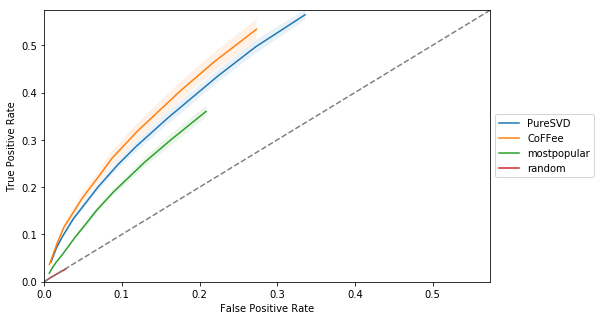

In [27]:
show_hit_rates(scores, errors=deviation, err_alpha=ERR_ALPHA)

old

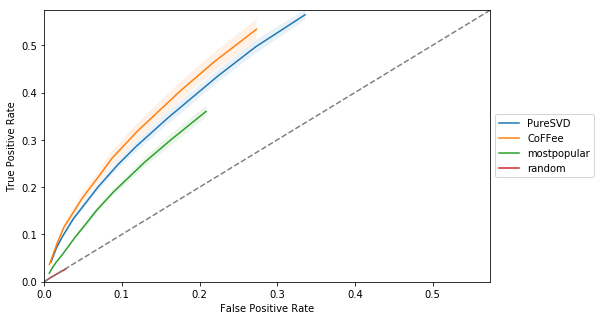

In [21]:
show_hit_rates(scores, errors=deviation, err_alpha=ERR_ALPHA)

new

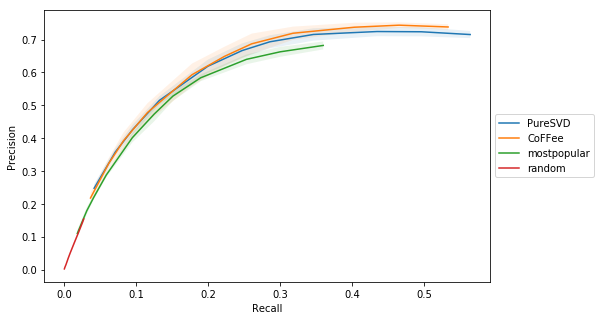

In [28]:
show_precision_recall(scores, errors=deviation, err_alpha=ERR_ALPHA)

old

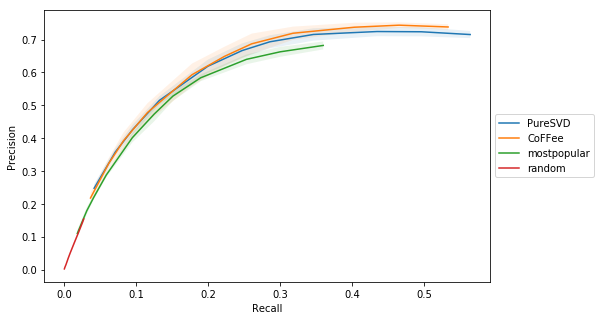

In [22]:
show_precision_recall(scores, errors=deviation, err_alpha=ERR_ALPHA)

new

In [29]:
scores['ranking']

,nDCG,nDCL,nDCG,nDCL,nDCG,nDCL,nDCG,nDCL
,PureSVD,PureSVD,CoFFee,CoFFee,mostpopular,mostpopular,random,random
top-n,,,,,,,,
1,0.077220,0.026973,0.069063,0.021159,0.034049,0.021976,0.000566,0.000467
2,0.111342,0.040239,0.098935,0.031965,0.049284,0.031109,0.000713,0.001039
3,0.132601,0.051971,0.117370,0.038646,0.057795,0.037549,0.001003,0.001382
5,0.159641,0.069481,0.142239,0.049600,0.070335,0.048499,0.001248,0.002106
10,0.197528,0.101178,0.177816,0.073176,0.091356,0.064922,0.001969,0.003559
15,0.219348,0.122217,0.198274,0.090254,0.105611,0.077387,0.002724,0.004495
20,0.234971,0.139544,0.213806,0.102701,0.116623,0.086674,0.003230,0.005779
30,0.256997,0.166981,0.235030,0.124551,0.130844,0.101282,0.004197,0.007288


old

In [23]:
scores['ranking']

,nDCG,nDCL,nDCG,nDCL,nDCG,nDCL,nDCG,nDCL
,PureSVD,PureSVD,CoFFee,CoFFee,mostpopular,mostpopular,random,random
top-n,,,,,,,,
1,0.077220,0.026973,0.069063,0.021159,0.034049,0.021976,0.000566,0.000467
2,0.111342,0.040239,0.098935,0.031965,0.049284,0.031109,0.000713,0.001039
3,0.132601,0.051971,0.117370,0.038646,0.057795,0.037549,0.001003,0.001382
5,0.159641,0.069481,0.142239,0.049600,0.070335,0.048499,0.001248,0.002106
10,0.197528,0.101178,0.177816,0.073176,0.091356,0.064922,0.001969,0.003559
15,0.219348,0.122217,0.198274,0.090254,0.105611,0.077387,0.002724,0.004495
20,0.234971,0.139544,0.213806,0.102701,0.116623,0.086674,0.003230,0.005779
30,0.256997,0.166981,0.235030,0.124551,0.130844,0.101282,0.004197,0.007288


new

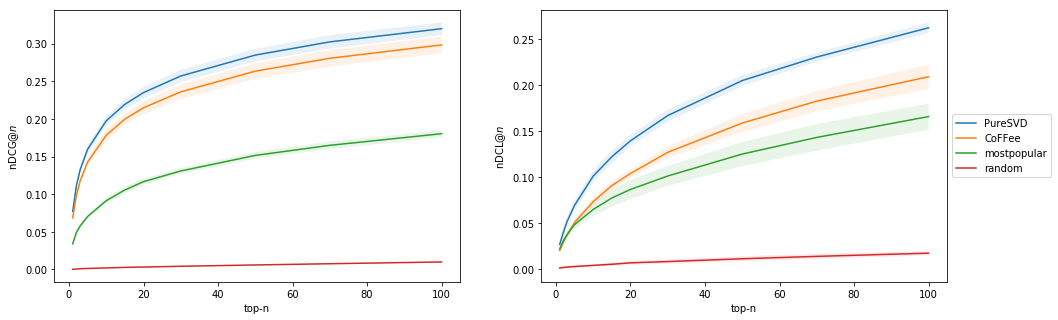

In [24]:
show_ranking(scores, errors=deviation, err_alpha=ERR_ALPHA)

old

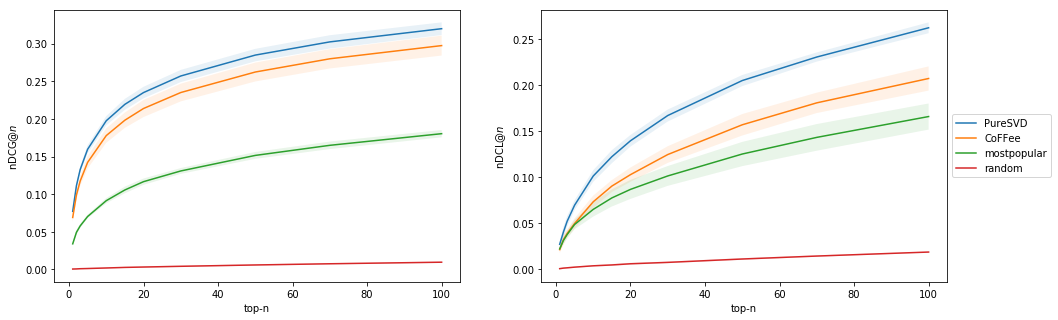

In [24]:
show_ranking(scores, errors=deviation, err_alpha=ERR_ALPHA)

## Predictions from single negative feedback

In [48]:
test_sample = -1

In [49]:
scores = {}
deviation = {}
scores['ranking'] = result[test_sample]['ranking'].mean(axis=0, level=1)
deviation['ranking'] = result[test_sample]['ranking'].std(axis=0, level=1)
scores['relevance'] = result[test_sample]['relevance'].mean(axis=0, level=1)
deviation['relevance'] = result[test_sample]['relevance'].std(axis=0, level=1)

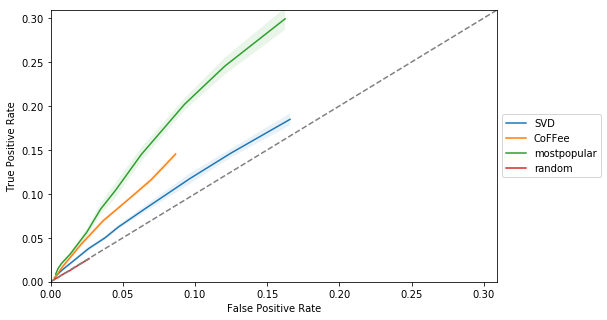

In [50]:
show_hit_rates(scores, errors=deviation, err_alpha=ERR_ALPHA)

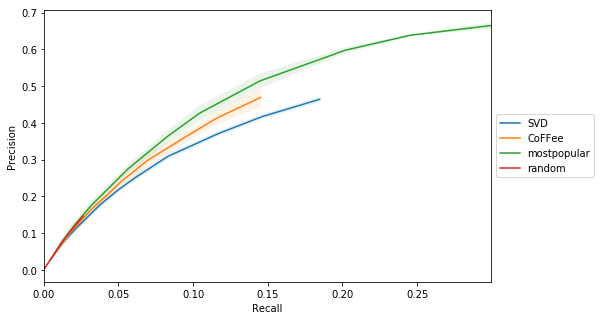

In [51]:
show_precision_recall(scores, errors=deviation, err_alpha=ERR_ALPHA)

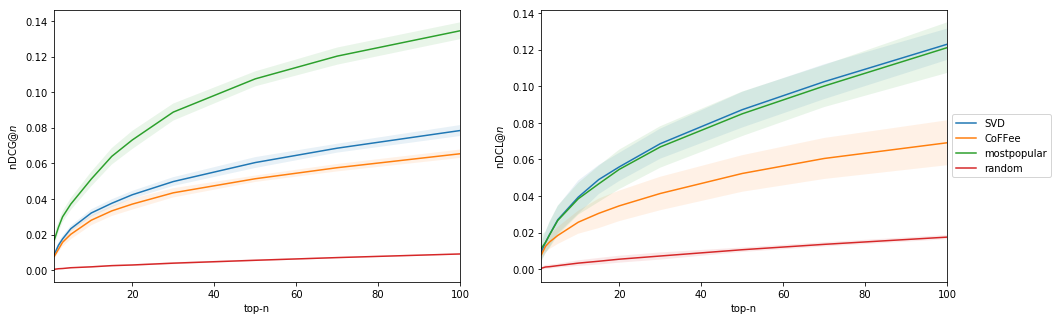

In [52]:
show_ranking(scores, errors=deviation, err_alpha=ERR_ALPHA)